Epoch 1, Loss: 164.0063
Epoch 2, Loss: 115.9308
Epoch 3, Loss: 109.3820
Epoch 4, Loss: 107.1880
Epoch 5, Loss: 105.9474


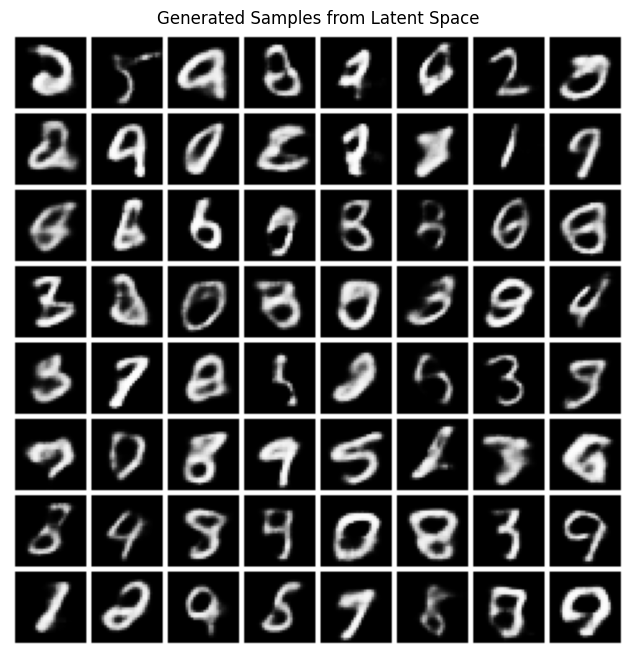

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the MNIST dataset
mnist_path = './data'
train_dataset = datasets.MNIST(root=mnist_path, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=mnist_path, train=False, download=True, transform=transform)
full_dataset = ConcatDataset([train_dataset, test_dataset])

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.fc1 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc2 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc3 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc1(x).squeeze()
        logvar = self.fc2(x).squeeze()
        return mu, logvar

    def decode(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)
        x = self.fc3(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training Function
def train_vae(model, dataset, config):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    data_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    for epoch in range(config['num_epochs']):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset):.4f}')
    
    # Save model
    os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)
    torch.save(model.state_dict(), config['save_path'])

# Sampling Function
def sample_from_vae(model, latent_dim, num_samples=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        grid = torchvision.utils.make_grid(samples, nrow=8, pad_value=1)
        plt.figure(figsize=(8, 8))
        plt.title("Generated Samples from Latent Space")
        plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

# Config
config = {
    'lr': 5e-4,
    'num_epochs': 5,
    'batch_size': 32,
    'save_path': 'models/vae_mnist.pth'
}

# Run Training
model = VAE(latent_dim=16)
train_vae(model, full_dataset, config)

# Load model & Sample
model.load_state_dict(torch.load(config['save_path'], map_location=device))
model.to(device)
sample_from_vae(model, latent_dim=16)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# ----------------------------------------
#   Simplified VAE2: Patch-only Residual Decoder
# ----------------------------------------
class SimpleVAE2(nn.Module):
    def __init__(self, patch_size=7):
        super().__init__()
        self.patch_size = patch_size
        self.decoder_fc = nn.Sequential(
            nn.Linear(patch_size * patch_size, 128),
            nn.ReLU(),
            nn.Linear(128, patch_size * patch_size),
            nn.Tanh()
        )

    def decode_patch(self, patch):
        pf = patch.contiguous().view(patch.size(0), -1)  # [B,49]
        out = self.decoder_fc(pf)                        # [B,49]
        return out.view(-1, 1, self.patch_size, self.patch_size)

    def extract_patches(self, img):
        patches = []
        idx = 0
        for i in range(0, 28, self.patch_size):
            for j in range(0, 28, self.patch_size):
                patches.append((img[:, :, i:i+self.patch_size, j:j+self.patch_size], idx))
                idx += 1
        return patches

    def stitch_patches(self, patches, shape):
        B, C, H, W = shape
        full = torch.zeros((B, C, H, W), device=patches[0][0].device)
        for patch, idx in patches:
            i, j = divmod(idx, H // self.patch_size)
            full[:, :, i*self.patch_size:(i+1)*self.patch_size,
                      j*self.patch_size:(j+1)*self.patch_size] += patch
        return full

    def forward(self, original, vae1_out):
        patches = self.extract_patches(vae1_out)
        res_patches = []
        for patch, idx in patches:
            rp = self.decode_patch(patch)
            res_patches.append((rp, idx))

        pred_residual = self.stitch_patches(res_patches, original.shape)
        return pred_residual
    
def simple_vae2_loss(orig, vae1_out, pred_residual):
    target_residual = orig - vae1_out
    
    count_significant = (target_residual.abs() > 0.2).sum().item()
    if count_significant > 10:
        mask = 5.0
    else:
        mask = 0.1     # less weightage to balance empty patches
    return mask*F.mse_loss(pred_residual, target_residual, reduction='sum')

def train_vae2(vae1, vae2, loader, config, device):
    vae2.to(device)
    vae1.to(device).eval()
    opt = optim.Adam(vae2.parameters(), lr=config['lr'])

    import matplotlib.pyplot as plt

    for epoch in range(config['num_epochs']):
        tot = 0.0
        for batch_idx, (imgs, _) in enumerate(loader):
            imgs = imgs.to(device)

            with torch.no_grad():
                mu1, log1 = vae1.encode(imgs)
                z1        = vae1.reparameterize(mu1, log1)
                O1        = vae1.decode(z1)

            residual = vae2(imgs, O1)
            loss = simple_vae2_loss(imgs, O1, residual)

            opt.zero_grad()
            loss.backward()
            opt.step()
            tot += loss.item()

        if epoch % 2 == 0:
            print('Images from epoch', epoch)
            for i in range(min(2, imgs.size(0))):
                fig, axs = plt.subplots(1, 4, figsize=(12, 3))
                axs[0].imshow(imgs[i, 0].cpu(), cmap='gray', vmin=0, vmax=1)
                axs[0].set_title("Original")
                axs[0].axis('off')

                axs[1].imshow(O1[i, 0].detach().cpu(), cmap='gray', vmin=0, vmax=1)
                axs[1].set_title("VAE1 Output")
                axs[1].axis('off')

                axs[2].imshow((imgs[i, 0] - O1[i, 0].detach()).cpu(), cmap='gray', vmin=-1, vmax=1)
                axs[2].set_title("Actual Residual")
                axs[2].axis('off')

                axs[3].imshow(residual[i, 0].detach().cpu(), cmap='gray', vmin=-1, vmax=1)
                axs[3].set_title("Pred Residual")
                axs[3].axis('off')

                plt.tight_layout()
                plt.show()

        print(f"Epoch {epoch+1}/{config['num_epochs']}  Loss: {tot/len(loader.dataset):.4f}")

    os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)
    torch.save(vae2.state_dict(), config['save_path'])


In [15]:

# ----------------------------------------
#   Generate and Compare Samples (VAE1 vs VAE1+VAE2)
# ----------------------------------------
def sample_and_compare(vae1, vae2, config, device, num_samples=8):
    """
    Samples from VAE1 and VAE2 pipeline and plots side-by-side on same [0,1] scale:
     - VAE1-only sample
     - Combined VAE1+VAE2 sample
    """
    vae1.eval()
    vae2.eval()
    import matplotlib.pyplot as plt
    with torch.no_grad():
        # 1) Sample z1 and generate base samples
        z1 = torch.randn(num_samples, config['latent_dim'], device=device)
        O1 = vae1.decode(z1)  # [num_samples,1,28,28]

        # 2) Generate residuals and combined output
        residual, _, _ = vae2(O1, O1, z1)
        O2 = torch.clamp(O1 + residual, 0, 1)    # with residual scaling

        # 3) Plot side-by-side with consistent scaling
        for i in range(num_samples):
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(O1[i,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[0].set_title('VAE1 Sample')
            axs[0].axis('off')

            axs[1].imshow(O2[i,0].cpu(), cmap='gray', vmin=0, vmax=1)
            axs[1].set_title('VAE1+VAE2 Sample')
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()


In [16]:

# ----------------------------------------
#  Example: reuse existing train_loader
# ----------------------------------------
if __name__ == "__main__":
    config = {
        'lr': 1e-4,
        'batch_size': 32,
        'num_epochs': 10,
        'patch_size': 7,
        'save_path': 'models/vae2_mnist.pth'
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Assume train_loader comes from VAE1 setup and dataset already downloaded
    # e.g. from previous script:
    # transform = transforms.ToTensor()
    # train_ds = datasets.MNIST('./data', train=True, download=False, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=config['batch_size'], shuffle=True)

    vae2 = SimpleVAE2( patch_size=config['patch_size']).to(device)

    train_vae2(model, vae2, train_loader, config, device)


UnboundLocalError: cannot access local variable 'target_residual' where it is not associated with a value

Model outputs are collapsing to 0